In [1]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import pylab as pl
import numpy as np

We have seen that studying the variability of an estimate involves questions such as:

- Where is the empirical histogram centered?
- About how far away from center could the values be?

In order to discuss estimates and their variability in greater detail, it will help to quantify some basic features of distributions.

###The mean of a list of numbers

In this course, we will use the words "average" and "mean" interchangeably.

**Definition**: The *average* or *mean* of a list of numbers is the sum of all the numbers in the list, divided by the number of entries in the list.

Here is the definition applied to a list of 20 numbers.

In [2]:
# The data: a list of numbers

x_list = [4, 4, 4, 5, 5, 5, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]

# The average

sum(x_list)/len(x_list)

3.15

The average of the list is 3.15. 

You can think of taking the mean as an "equalizing" or "smoothing" operation. For example, imagine the entries in ``x_list`` being the amounts of money (in dollars) in the pockets of 20 different people. To get the mean, you first put all of the money into one big pot, and then divide it evenly among all 20 people. They had started out with different amounts of money in their pockets, but now each person has $3.15, the average amount.

**Computation:** We could instead have found the mean by applying the function ``np.mean`` to the list ``x_list``. Differences in rounding lead to answers that differ very slightly.

In [3]:
np.mean(x_list)

3.1499999999999999

Or we could have placed the list in a table, and used the Table method ``mean``:

In [4]:
x_table = Table().with_column('value', x_list)
x_table['value'].mean()

3.1499999999999999

###The mean and the histogram

Another way to calculate the mean is to first arrange the list in a distribution table. The columns contain the distinct values in the list, the count of each value, and the corresponding proportion. The sum of the column ``count`` is 20, the number of entries in the list. 

In [5]:
x_dist = Table(['value', 'count'])
x_dist = x_dist.with_rows([
                          [2, 6], 
                          [3, 8], 
                          [4, 3], 
                          [5, 3] 
                         ])
x_dist['proportion'] = x_dist['count']/sum(x_dist['count'])

# the distribution table
x_dist

value,count,proportion
2,6,0.3
3,8,0.4
4,3,0.15
5,3,0.15


The sum of the numbers in the list can be calculated by multiplying the first two columns and adding up – four 2's, five 3's, and so on – and then dividing by 20:

In [6]:
sum(x_dist['value']*x_dist['count'])/sum(x_dist['count'])

3.1499999999999999

This is the same as multiplying the first and third columns – the values and their proportions – and adding up:

In [7]:
sum(x_dist['value']*x_dist['proportion'])

3.1500000000000004

We now have **another way to think about the mean:** The mean of a list is the *weighted* average of the *distinct* values, where the *weights are the proportions* in which those values appear.

Physically, this implies that **the average is the balance point of the histogram**. Here is the histogram of the distribution. Imagine that it is made out of cardboard and that you are trying to balance the cardboard figure at a point on the horizontal axis. The average of 3.15 is where the figure will balance. 

To understand why that is, you will have to study some physics. Balance points, or centers of gravity, can be calculated in exactly the way we calculated the mean from the distribution table.

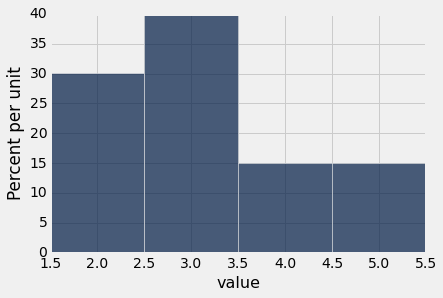

In [17]:
x_dist.select(['value', 'proportion']).hist(counts='value', bins=np.arange(1.5, 5.6, 1))

Notice that the mean of a list depends only on the distinct values and their proportions; you do not need to know how many entries there are in the list. 

In other words, the average is a property of the histogram. If two lists have the same histogram, they will also have the same average.


###The mean and the median

If a student's score on a test is below average, does that mean that the student is in the bottom half of the class on that test?

Happily for the student, the answer is, "Not necessarily." The reason has to do with the relation between the average, which is the balance point of the histogram, and the median, which is the "half-way point" of the data.

Let's compare the balance point of the histogram to the point that has 50% of the area of the histogram on either side of it.

The relationship is easy to see in a simple example. Here is the list 1, 2, 2, 3, represented as a distribution table called ``sym`` for "symmetric".

In [9]:
sym = Table().with_columns([
        'value', [1,2,3],
        'dist', [0.25,0.5,0.25]
        ])
sym

value,dist
1,0.25
2,0.5
3,0.25


The histogram (or a calculation) shows that the average and median are both 2.

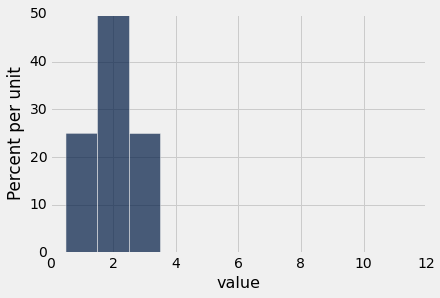

In [16]:
sym.hist(counts='value', bins=np.arange(0.5, 10.6, 1))

In general, for **symmetric distributions**, the mean and the median are equal.

What if the distribution is not symmetric? We will explore this by making a change in the histogram above: we will take the bar at the value 3 and slide it over to the value 10.

In [11]:
# Average versus median:
# Balance point versus 50% point

slide = Table().with_columns([
        'value', [1,2,3,10], 
        'dist1',[0.25, 0.5, 0.25, 0], 
        'dist2',[0.25, 0.5, 0, 0.25] 
        ])
slide

value,dist1,dist2
1,0.25,0.25
2,0.5,0.5
3,0.25,0
10,0,0.25


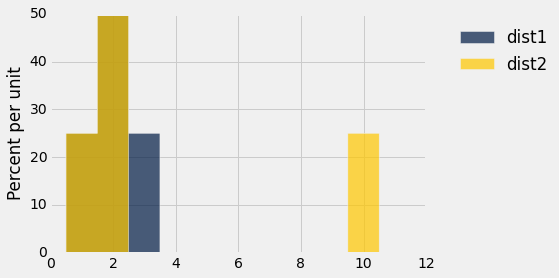

In [15]:
slide.hist(counts='value', bins=np.arange(0.5, 10.6, 1))

The blue histogram represents the original distribution; the gold histogram starts out the same as the blue at the left end, but its rightmost bar has slid over to the value 10. The brown part is where the two histograms overlap.

The median and mean of the blue distribution are both equal to 2. The median of the gold distribution is also equal to 2; the area on either side of 2 is still 50%, though the right half is distributed differently from the left. 

But the mean of the gold distribution is not 2: the gold histogram would not balance at 2. The balance point has shifted to the right, to 3.75.

In [13]:
sum(slide['value']*slide['dist2'])

3.75

In the gold distribution, 3 out of 4 entries (75%) are below average. The student with a below average score can therefore take heart. He or she might be in the majority of the class.

**The mean, the median, and skewed distributions:** In general, if the histogram has a tail on one side (the formal term is "skewed"), then the mean is pulled away from the median in the direction of the tail.

**Example: Flight Delays.** The Bureau of Transportation Statistics provides data on departures and arrivals of flights in the United States. The table ``ua`` contains the departure delay times, in minutes, of about 37,500 United Airlines flights over the past few years. A negative delay means that the flight left earlier than scheduled. 

In [34]:
ontime = Table.read_table('airline_ontime.csv')

In [85]:
ua1 = ontime.where('CARRIER', 'UA')
ua_delays = ua1['DEP_DELAY']
ua_delays = [x for x in ua_delays if str(x) != 'nan']
ua = Table().with_column('Departure Delay', ua_delays)

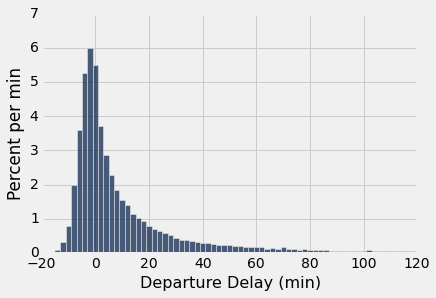

In [86]:
plotrange = np.arange(-15, 121, 2)
ua.hist(bins=plotrange, unit='min')

The histogram of the delay times is right-skewed: it has a long right hand tail.

The mean gets pulled away from the median in the direction of the tail. So we expect the mean delay to be larger than the median, and that is indeed the case:

In [87]:
np.mean(ua['Departure Delay'])

14.010359374165644

In [88]:
np.median(ua['Departure Delay'])

2.0